In [1]:
import numpy as np

In [2]:
lines = [line.rstrip('\n') for line in open('nursery.data.txt')]

In [3]:
print(lines[0])
row = lines[0].split(',')
print(row)

usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
['usual', 'proper', 'complete', '1', 'convenient', 'convenient', 'nonprob', 'recommended', 'recommend']


In [4]:
attr_names = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health']

In [186]:
attr_list = [['usual', 'pretentious','great_pret'],
['proper','less_proper','improper','critical','very_crit'],
['complete', 'completed', 'incomplete', 'foster'],
['1', '2', '3', 'more'],
['convenient', 'less_conv', 'critical'],
['convenient', 'inconv'],
['nonprob', 'slightly_prob', 'problematic'],
['recommended', 'priority', 'not_recom'],
['not_recom', 'recommend', 'very_recom', 'priority', 'spec_prior']]
print(attr_list[8])
class_name = ['not_recom', 'priority', 'spec_prior']

['not_recom', 'recommend', 'very_recom', 'priority', 'spec_prior']


In [187]:
base = 1
for i in range(8):
    base *= len(attr_list[i])
print(base)

12960


In [188]:
data = []
for i in range(len(lines)-1):
    row = lines[i].split(',')
#     print(row)
    sample = []
    for j in range(len(row)):
#         print(attr_list[j])
#         print(row[j])
        sample.append(attr_list[j].index(row[j]))
#     print(sample)
    if sample[8] != 2 and sample[8] != 1:
        data.append(sample)
#     data.append(sample)
data = np.asarray(data)
print(data.shape)

(12630, 9)


In [216]:
feature = data[:,0:8]
label = data[:,8].reshape(-1, 1)
print(np.unique(label))
label[label==3] = 1
label[label==4] = 2
print(np.unique(label))

[0 3 4]
[0 1 2]


In [217]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from pomegranate import BayesianNetwork
from sklearn.model_selection import train_test_split
import copy
import warnings
warnings.filterwarnings('ignore')


def predict_with(model_name='None', train=None):
    # BN_name = exact, greedy, chow-liu
    if model_name == 'GaussianNB':
        return GaussianNB()
    if model_name == 'MultinomialNB':
        return MultinomialNB()
    if model_name == 'kernel_SVM':
        return svm.SVC(gamma='scale', decision_function_shape='ovo')
    if model_name == 'linear_SVM':
        return svm.LinearSVC()
    if model_name == 'LogisticRegression':
        return LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    if model_name == 'DecisionTree':
        return tree.DecisionTreeClassifier()
    if model_name == 'MLP':
        return MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    if model_name == 'PO-exact':
        return BayesianNetwork.from_samples(train, algorithm='exact', pseudocount=1)
    if model_name == 'PO-greedy':
        return BayesianNetwork.from_samples(train, algorithm='greedy', pseudocount=1)
    if model_name == 'PO-chow-liu':
        return BayesianNetwork.from_samples(train, algorithm='chow-liu', pseudocount=1)
    

In [244]:
def random_flip(y_train, flip_ratio, cs_matrix):
    label_list = np.unique(y_train)
    flip_y_train = copy.deepcopy(y_train)
    count_flip = 0
    for idx in range(y_train.shape[0]):
        rand_flip = np.random.rand()
        if rand_flip<flip_ratio:
            count_flip += 1
            rand_trans = np.random.rand()
            ori_label = flip_y_train[idx]
            idx_row = np.where(label_list == ori_label)[0]
            trans_row = cs_matrix[idx_row,:]
            diff_row = np.sign(trans_row - rand_trans)
            flip_label = label_list[np.where(diff_row[0] == 1)[0][0]]
            flip_y_train[idx] = flip_label
    return flip_y_train

def feature_test(X_train, X_test, y_train, y_test):
    flag = False
    for idx_fea in range(X_train.shape[1]):
            x1 = np.unique(X_train[:,idx_fea])
            x2 = np.unique(X_test[:,idx_fea])
            if np.array_equal(x1,x2) != True:
                flag = True
                break
    return flag

def split_dataset(feature, label, test_size=0.3, random_state=42):
    # Keep iterating until every possible value in feature space appear in both datasets.
    flag = True
    
    while flag:
        X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=test_size, random_state=random_state)
        flag = feature_test(X_train, X_test, y_train, y_test)
    
    return X_train, X_test, y_train, y_test

In [241]:
# Repeat K times
from tqdm import tqdm

model_name_list = ['GaussianNB', 'MultinomialNB', 'kernel_SVM', 'linear_SVM',
                   'LogisticRegression', 'DecisionTree',
                   'PO-exact', 'PO-greedy', 'PO-chow-liu']
flip_min = 0
flip_max = 0.3
flip_step = 0.05
peru_list = np.arange(flip_min,flip_max+flip_step,flip_step)
n_rpt = 5
n_model = len(model_name_list)
n_peru = len(peru_list)
ratio_train_test = 0.3
flip_trans_matrix = np.array([[0, 0.5, 0.5],
                              [0.5, 0, 0.5],
                              [0.5, 0.5, 0]])
flip_trans_matrix_cum_sum = np.cumsum(flip_trans_matrix,axis=1)

print("This experiments will be operated for %d times for average performance." % n_rpt)
print("The dataset population：")
print("--", "Training:", 1-ratio_train_test)
print("--", "Testing:", ratio_train_test)
print("The transition matrix of flipping:")
print(flip_trans_matrix)
print("The transition matrix of flipping (cumulative sum):")
print(flip_trans_matrix_cum_sum)
print("%d models will be tested." % n_model)
for ins in model_name_list:
    print("--",ins)
print("%d different pertubation will be made." % (n_peru))
print("--", peru_list[0]*100, '%')
print("--", peru_list[1]*100, '%')
print("--", "...")
print("--", peru_list[-1]*100, '%')

This experiments will be operated for 5 times for average performance.
The dataset population：
-- Training: 0.7
-- Testing: 0.3
The transition matrix of flipping:
[[0.  0.5 0.5]
 [0.5 0.  0.5]
 [0.5 0.5 0. ]]
The transition matrix of flipping (cumulative sum):
[[0.  0.5 1. ]
 [0.5 0.5 1. ]
 [0.5 1.  1. ]]
9 models will be tested.
-- GaussianNB
-- MultinomialNB
-- kernel_SVM
-- linear_SVM
-- LogisticRegression
-- DecisionTree
-- PO-exact
-- PO-greedy
-- PO-chow-liu
7 different pertubation will be made.
-- 0.0 %
-- 5.0 %
-- ...
-- 30.000000000000004 %


In [242]:
feature = data[:,0:8]
label = data[:,8].reshape(-1, 1)
X = feature
y = label
error_rate = np.zeros((n_rpt,n_model,n_peru))
print("X dimension:", X.shape)
print("y dimension:", y.shape)
print("Error rate matrix dimension:", error_rate.shape)

X dimension: (12630, 8)
y dimension: (12630, 1)
Error rate matrix dimension: (5, 9, 7)


In [246]:
with tqdm(total=n_rpt*n_model*n_peru) as pbar:
    for idx_rpt in range(n_rpt):
        # get acceptable dataset
        X_train, X_test, y_train, y_test = split_dataset(feature, label, test_size=ratio_train_test)
        for idx_peru in range(n_peru):
            # random flip
            flip_ratio = peru_list[idx_peru]
            flip_y_train = random_flip(y_train, flip_ratio=peru_list[idx_peru], cs_matrix=flip_trans_matrix_cum_sum)
            for idx_model in range(n_model):
                model_name = model_name_list[idx_model]
                if model_name[0:2] != 'PO':
                    y_pred = predict_with(model_name).fit(X_train, flip_y_train).predict(X_test).reshape(-1, 1)
                if model_name[0:2] == 'PO':
                    po_X_test = X_test.tolist()
                    for ins in po_X_test:
                        ins.append(None)
                    train = np.hstack((X_train,y_train))
                    y_pred = np.array(predict_with(model_name, train).predict(po_X_test), dtype=np.int64)[:,-1]
                    y_pred = y_pred.reshape(-1, 1)
                error_rate[idx_rpt, idx_model, idx_peru] = (float((y_test != y_pred).sum())/X_test.shape[0])
                pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████| 315/315 [22:46<00:00,  8.00s/it]


In [247]:
import pandas as pd
er_list = []
er_mean = np.mean(error_rate, axis=0)
for idx_rpt in range(n_rpt):
    for idx_model in range(n_model):
        for idx_peru in range(n_peru):
            er_list.append([idx_rpt,
                            model_name_list[idx_model],
                            peru_list[idx_peru], 
                            er_mean[idx_model, idx_peru]])
er_df = pd.DataFrame(er_list, columns=['idx', 'model', 'flip_rate', 'error_rate'], dtype=float)
# print(er_df)

In [248]:
print(er_df.shape)

(315, 4)


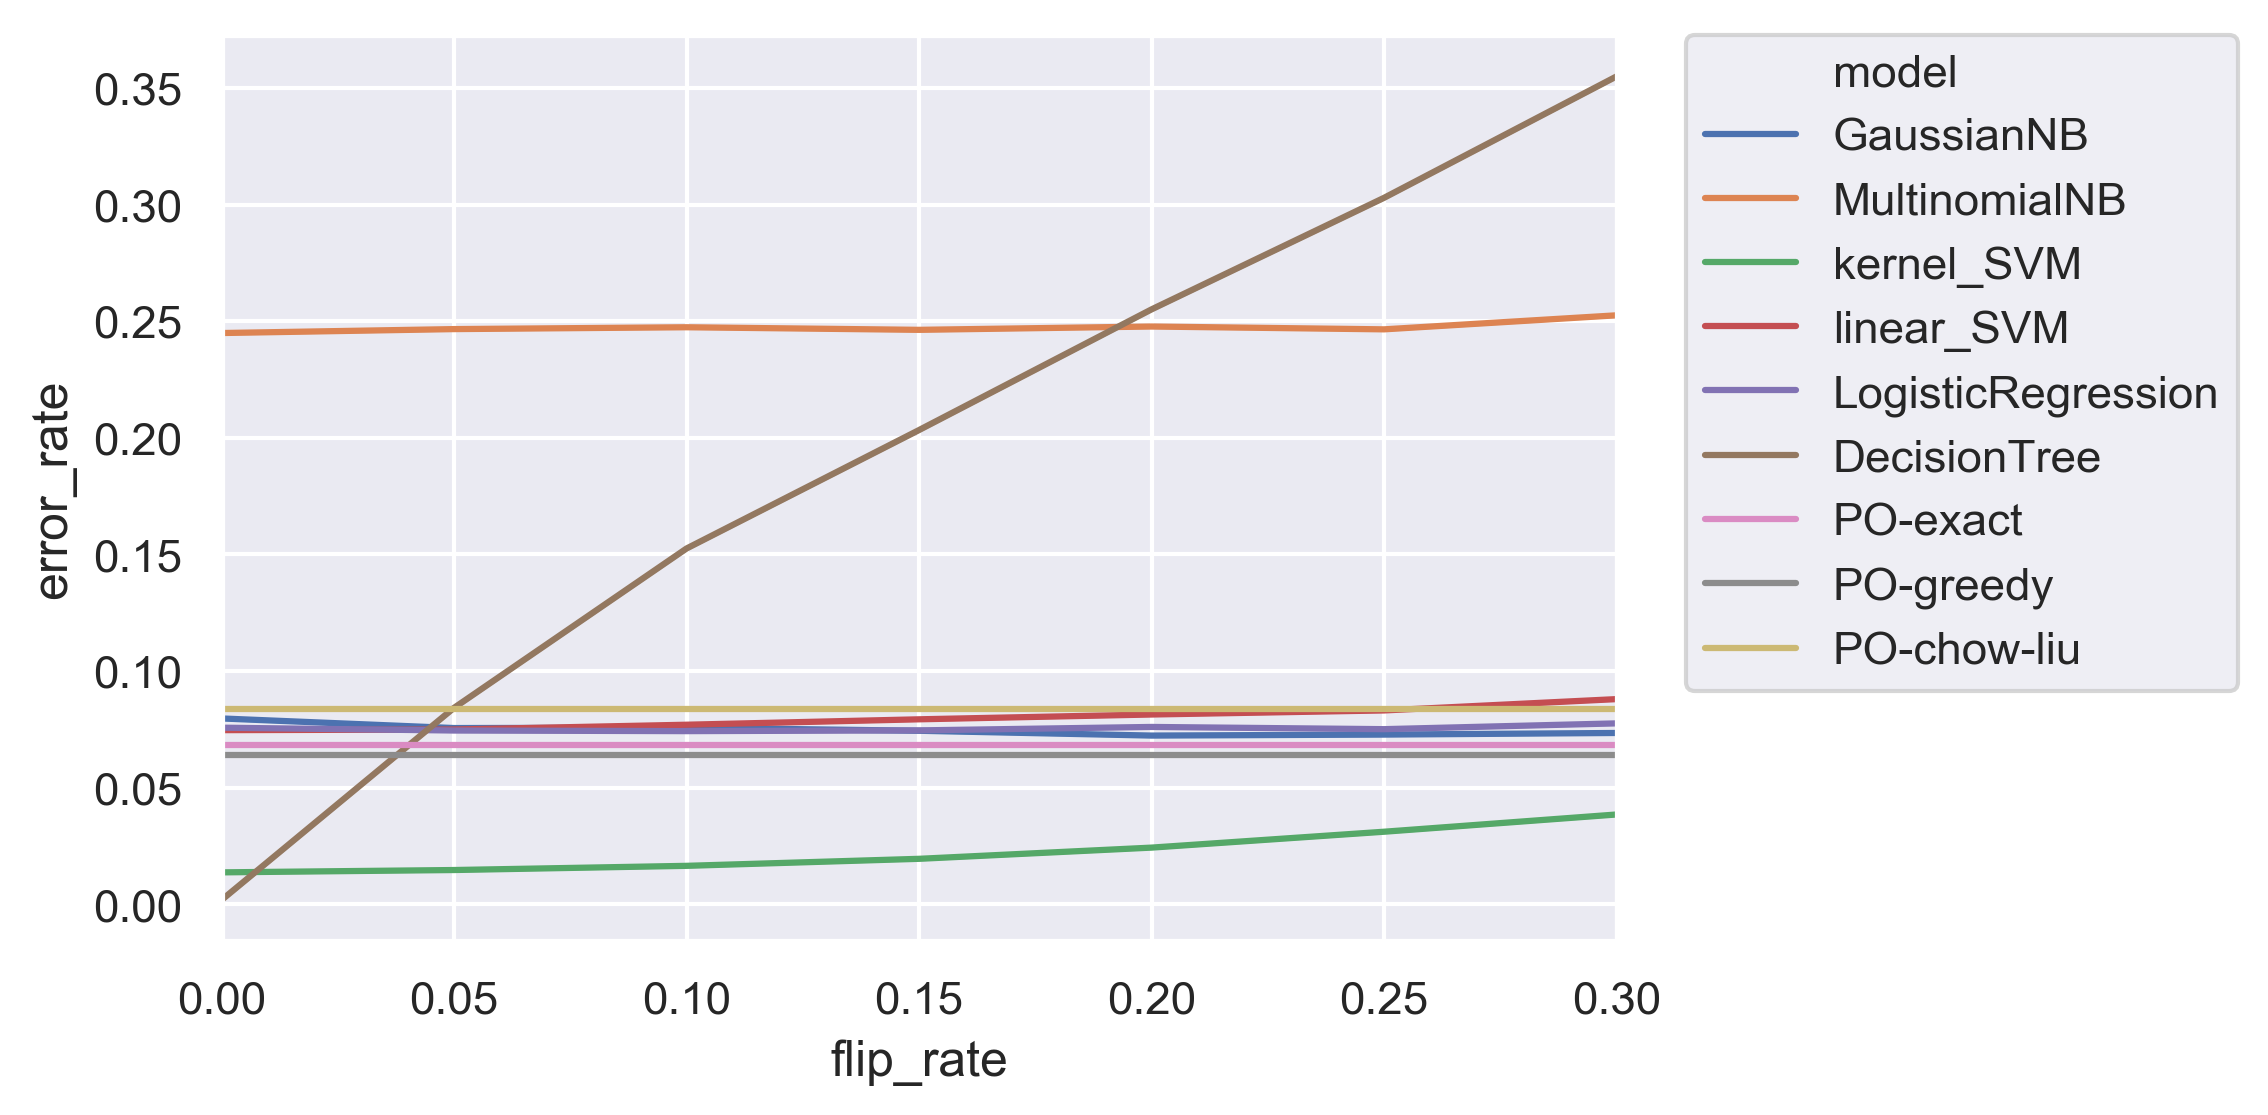

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=300)
sns.set(style="darkgrid")


# Plot the responses for different events and regions
ax = sns.lineplot(x="flip_rate", y="error_rate",
                  hue="model", data=er_df, legend='full')
ax.set(xlim=(0, 0.3))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [19]:
# K-fold
from sklearn.model_selection import KFold
from tqdm import tqdm

n_fold = 10
feature = data[:,0:8]
label = data[:,8].reshape(-1, 1)
X = feature
y = label
kf = KFold(n_splits=n_fold)
kf.get_n_splits(X)

# print(kf)  

model_name_list = ['GaussianNB', 'MultinomialNB', 'kernel_SVM', 'linear_SVM',
                   'LogisticRegression', 'DecisionTree']
#                    'PO-exact', 'PO-greedy', 'PO-chow-liu']

error_rate = np.zeros((n_fold,len(model_name_list),4))

with tqdm(total=n_fold) as pbar:
    for idx_fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        flip_10_y_train = label_flip(y_train, ratio=0.1)
        flip_20_y_train = label_flip(y_train, ratio=0.2)
        flip_30_y_train = label_flip(y_train, ratio=0.3)
        for idx_model, model_name in enumerate(model_name_list):
            if model_name[0:2] != 'PO':
                y_pred = predict_with(model_name).fit(X_train, y_train).predict(X_test).reshape(-1, 1)
                flip_10_y_pred = predict_with(model_name).fit(X_train, flip_10_y_train).predict(X_test).reshape(-1, 1)
                flip_20_y_pred = predict_with(model_name).fit(X_train, flip_20_y_train).predict(X_test).reshape(-1, 1)
                flip_30_y_pred = predict_with(model_name).fit(X_train, flip_30_y_train).predict(X_test).reshape(-1, 1)
            if model_name[0:2] == 'PO':
                po_X_test = X_test.tolist()
                for ins in po_X_test:
                    ins.append(None)
                    
                train = np.hstack((X_train,y_train))
                y_pred = np.array(predict_with(model_name, train).predict(po_X_test), dtype=np.int64).reshape(-1, 1)
                flip_10_train = np.hstack((X_train,flip_10_y_train))
                flip_10_y_pred = np.array(predict_with(model_name, flip_10_train).predict(po_X_test), dtype=np.int64).reshape(-1, 1)
                flip_20_train = np.hstack((X_train,flip_20_y_train))
                flip_20_y_pred = np.array(predict_with(model_name, flip_20_train).predict(po_X_test), dtype=np.int64).reshape(-1, 1)
                flip_30_train = np.hstack((X_train,flip_30_y_train))
                flip_30_y_pred = np.array(predict_with(model_name, flip_30_train).predict(po_X_test), dtype=np.int64).reshape(-1, 1)
                
            
            error_rate[idx_fold, idx_model,0] = (float((y_test != y_pred).sum())/X_test.shape[0])
            error_rate[idx_fold, idx_model,1] = (float((y_test != flip_10_y_pred).sum())/X_test.shape[0])
            error_rate[idx_fold, idx_model,2] = (float((y_test != flip_20_y_pred).sum())/X_test.shape[0])
            error_rate[idx_fold, idx_model,3] = (float((y_test != flip_30_y_pred).sum())/X_test.shape[0])
        pbar.update(1)

print("Finished")
        


        
    

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [03:00<00:00, 17.46s/it]


Finished


In [22]:
for idx in range(len(model_name_list)):
    print(model_name_list[idx])
    for idx_er in range(4):
        print(np.mean(error_rate[:,idx,idx_er], axis=0))

GaussianNB
0.1058590657165479
0.09714964370546318
0.11013460015835312
0.10775930324623913
MultinomialNB
0.3057007125890736
0.29976247030878855
0.30292953285827395
0.30673000791765637
kernel_SVM
0.040142517814726844
0.0386381631037213
0.06334125098970703
0.07355502771179731
linear_SVM
0.09461599366587489
0.0939034045922407
0.10364212193190814
0.10965954077593032
LogisticRegression
0.09192399049881236
0.09224069675376088
0.10102929532858274
0.10182106096595407
DecisionTree
0.08060174188440222
0.17418844022169436
0.27125890736342045
0.35312747426761676


In [64]:
np.random.seed(12312)

n_fold = 5
feature = data[:,0:8]
label = data[:,8].reshape(-1, 1)
X = feature
y = label
kf = KFold(n_splits=n_fold)
kf.get_n_splits(X)

for i_rs in range(2000):
    rs = i_rs + 4000
    np.random.seed(rs)
    flag = True
    for idx_fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        bool_array = []
        for i in range(8):
            x1 = np.unique(X_train[:,i])
            x2 = np.unique(X_test[:,i])
            if np.array_equal(x1,x2) != True:
                flag = False
                
    if flag:
        print(rs)
print('Over')

Over


GaussianNB
0.44972288202692
0.44291369754552656
0.4477434679334917
0.44323040380047507
MultinomialNB
0.5507521773555029
0.5493269992082344
0.5456848772763262
0.534916864608076
kernel_SVM
0.12351543942992875
0.14196357878068092
0.18345209817893904
0.2358669833729216
linear_SVM
0.22256532066508314
0.23159144893111638
0.2730799683293745
0.29429928741092637
LogisticRegression
0.20886777513855898
0.1897070467141726
0.2119556611243072
0.23040380047505937
DecisionTree
0.23341250989707046
0.30815518606492476
0.38131433095803646
0.42494061757719714


In [140]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, random_state=42)

In [148]:
flip_y_train = label_flip(y_train, ratio=0.1)
print(np.int(y_train.shape[0]*0.1)*2.7)
print(np.sum(y_train-flip_y_train))

2386.8
64


In [9]:



y_pred = gnb.fit(X_train, y_train).predict(X_test).reshape(-1, 1)
print(y_pred.shape)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))
print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

(3789, 1)
Number of mislabeled points out of a total 3789 points : 302
The error rate is: 0.079704 


/Users/Deep_Learning/anaconda3/envs/dl_basic/lib/python2.7/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[1307,    0,    0],
       [   0, 1135,  146],
       [   0,  156, 1045]])

In [10]:
import numpy as np



clf.fit(X_train, y_train)

y_pred = clf.predict(X_test).reshape(-1, 1)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Number of mislabeled points out of a total 3789 points : 928
The error rate is: 0.244920 


array([[1289,   18,    0],
       [ 258,  732,  291],
       [  46,  315,  840]])

In [11]:



clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test).reshape(-1, 1)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Number of mislabeled points out of a total 3789 points : 52
The error rate is: 0.013724 


array([[1307,    0,    0],
       [   0, 1255,   26],
       [   0,   26, 1175]])

In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)

y_pred = clf.predict(X_test).reshape(-1, 1)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Number of mislabeled points out of a total 3789 points : 287
The error rate is: 0.075746 


/Users/Deep_Learning/anaconda3/envs/dl_basic/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


array([[1307,    0,    0],
       [   0, 1150,  131],
       [   0,  156, 1045]])

In [24]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test).reshape(-1, 1)

print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Number of mislabeled points out of a total 3789 points : 6
The error rate is: 0.001584 


array([[1307,    0,    0],
       [   0, 1277,    4],
       [   0,    2, 1199]])

Number of mislabeled points out of a total 3789 points : 4
The error rate is: 0.001056 


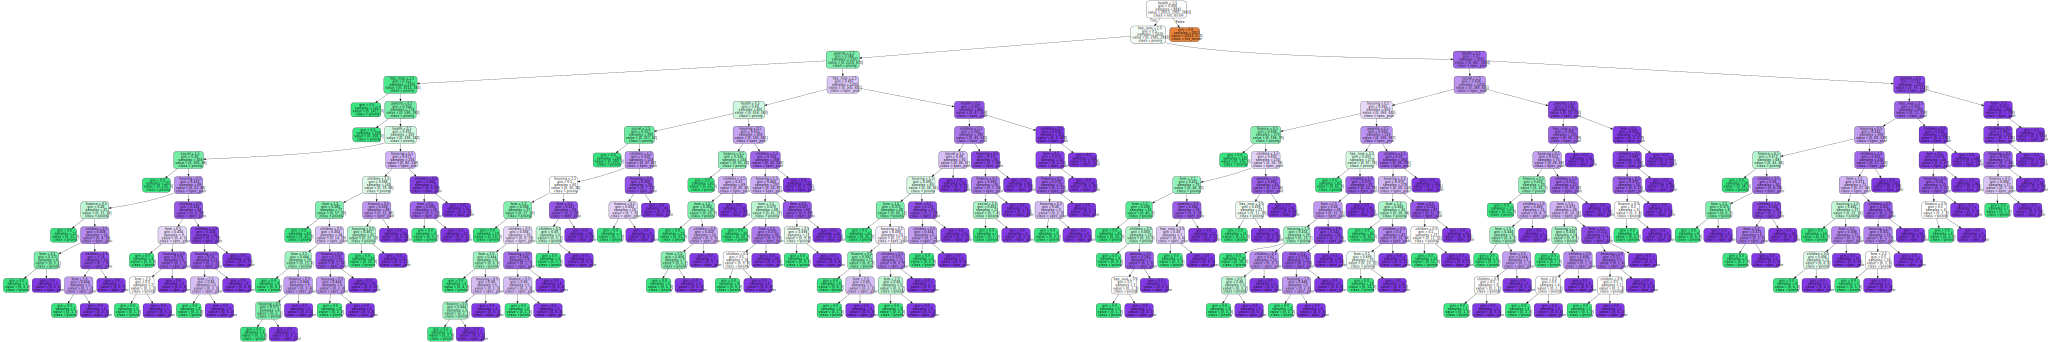

In [23]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=attr_names,  
                     class_names=class_name,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("DT_Nursery") 
graph

In [41]:
print(X_train.shape)
print(y_train.shape)
train = np.hstack((X_train,y_train))
print(train.shape)
test = np.hstack((X_test, y_test))
print(test.shape)
list_X_test = X_test.tolist()
for ins in list_X_test:
    ins.append(None)

(11367, 8)
(11367, 1)
(11367, 9)
(1263, 9)


In [50]:
import time

model = BayesianNetwork.from_samples(train, algorithm='exact') # << Default BNSL setting
tic = time.time()
list_y_pred = model.predict(list_X_test)
t = time.time() - tic
print "Time (s): ", t

# print(list_y_pred)
# y_pred = []
# for ins in list_y_pred:
#     y_pred.append(ins[-1])
# y_pred = np.array(y_pred).reshape(-1, 1)
# print(y_pred.shape)

# y_pred = np.array(list_y_pred)[:,-1].reshape(-1, 1)
# print(y_pred.shape)


# print("Number of mislabeled points out of a total %d points : %d"
#       % (X_test.shape[0],(y_test != y_pred).sum()))

# print("The error rate is: %f " 
#       % (float((y_test != y_pred).sum())/X_test.shape[0]))

# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test, y_pred)


# p = model.log_probability(data).sum()

# print "Chow-Liu"

# print "P(D|M): ", p
# print model.structure

# %memit BayesianNetwork.from_samples(X, algorithm='chow-liu')


Time (s):  20.6162550449
[array([0, 0, 0, 0, 0, 0, 0, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 0, 0, 2, 0], dtype=object), array([0, 0, 0, 0, 0, 0, 1, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 0, 1, 2, 0], dtype=object), array([0, 0, 0, 0, 0, 0, 2, 0, 3], dtype=object), array([0, 0, 0, 0, 0, 0, 2, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 0, 2, 2, 0], dtype=object), array([0, 0, 0, 0, 0, 1, 0, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 1, 0, 2, 0], dtype=object), array([0, 0, 0, 0, 0, 1, 1, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 1, 1, 2, 0], dtype=object), array([0, 0, 0, 0, 0, 1, 2, 0, 3], dtype=object), array([0, 0, 0, 0, 0, 1, 2, 1, 3], dtype=object), array([0, 0, 0, 0, 0, 1, 2, 2, 0], dtype=object), array([0, 0, 0, 0, 1, 0, 0, 1, 3], dtype=object), array([0, 0, 0, 0, 1, 0, 0, 2, 0], dtype=object), array([0, 0, 0, 0, 1, 0, 1, 1, 3], dtype=object), array([0, 0, 0, 0, 1, 0, 1, 2, 0], dtype=object), array([0, 0, 0, 0, 1, 0, 2, 0, 3], dtype=object), array([0, 0, 0, 0, 1, 0,

In [62]:
y_pred = np.array(list_y_pred)[:,-1].reshape(-1, 1)
print(y_pred.shape)
print(y_test.shape)

(1263, 1)
(1263, 1)


In [63]:
print(y_pred[0:10])

[[3]
 [0]
 [3]
 [0]
 [3]
 [3]
 [0]
 [3]
 [0]
 [3]]


In [53]:
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0],(y_test != y_pred).sum()))

print("The error rate is: %f " 
      % (float((y_test != y_pred).sum())/X_test.shape[0]))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

Number of mislabeled points out of a total 1263 points : 0
The error rate is: 0.000000 


ValueError: Classification metrics can't handle a mix of binary and unknown targets